## Install librosa

In [2]:
! pip install librosa

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


---

## .wav Data to MFCC
 **DATA_PATH = "./words/"**

In [1]:
import librosa
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
from tqdm import tqdm

DATA_PATH = "./words/"

Using TensorFlow backend.


In [2]:
# Input: Folder Path
# Output: Tuple (Label, Indices of the labels, one-hot encoded labels)
def get_labels(path=DATA_PATH):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)

In [3]:
# Handy function to convert wav2mfcc
def wav2mfcc(file_path, max_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=16000)

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')  # pad into same length

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc

In [4]:
# 從目錄夾讀取所有音檔，並將向量根據類別名稱存成 .npy 檔
def save_data_to_array(path=DATA_PATH, max_len=11):
    labels, _, _ = get_labels(path)

    for label in labels:
        # Init mfcc vectors
        mfcc_vectors = []

        wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        for wavfile in tqdm(wavfiles, "Saving vectors of label - '{}'".format(label)):
            mfcc = wav2mfcc(wavfile, max_len=max_len)
            mfcc_vectors.append(mfcc)
        np.save("./recognize/" + label + '.npy', mfcc_vectors)

## Save .npy in "./recognize/.."

In [5]:
def get_train_test(split_ratio=0.6, random_state=42):
    # Get available labels
    labels, indices, _ = get_labels(DATA_PATH)
    print(labels)
    # Getting first arrays
    X = np.load(DATA_PATH + labels[0] )
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load(DATA_PATH + label )
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))

    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)

---

## keras part

In [6]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
# With Tensorboard
from keras.callbacks import TensorBoard

# Second dimension of the feature is dim2
feature_dim_2 = 11

# Save data to array file first
save_data_to_array(max_len=feature_dim_2)


Saving vectors of label - 'zero': 100%|███████████████████████████████████████████| 4050/4050 [00:18<00:00, 219.21it/s]


In [7]:
DATA_PATH = "./recognize/"

# Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

['one.npy', 'three.npy', 'two.npy', 'zero.npy']


In [8]:
X_train.shape

(9324, 20, 11)

In [9]:
# # Feature dimension
feature_dim_1 = 20
channel = 1
epochs = 15 #3_20 18 / 2_15 14
batch_size = 100
num_classes = 4

# Reshaping to perform 2D convolution
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

In [10]:
model = Sequential()

# convolution, max pooling 
model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


# flattening
model.add(Flatten())


# fully connected
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.45))
#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

In [11]:
model.compile(loss='categorical_crossentropy',
            optimizer='Adam',
            metrics=['accuracy'])

In [12]:
# TensorBoard
tbRecord = TensorBoard(log_dir='./logs', 
                       histogram_freq=0, 
                       batch_size=batch_size, 
                       write_graph=True, 
                       write_grads=True, 
                       write_images=True, 
                       embeddings_freq=0, 
                       embeddings_layer_names=None, 
                       embeddings_metadata=None, 
                       embeddings_data=None, 
                       update_freq='epoch')

# ref. https://keras.io/callbacks/

__Open Anaconda-Prompt__  
__cd to log_dir & check out which log you will show:　tensorboard --logdir ./logs__  

__Show in: http://localhost:6006__

In [13]:
#build and train record
history = model.fit(X_train, y_train_hot, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_data=(X_test, y_test_hot),
                    callbacks=[tbRecord])

Train on 9324 samples, validate on 6217 samples
Epoch 1/15
9324/9324 [==============================] - ETA: 22s - loss: 10.6701 - acc: 0.260 - ETA: 9s - loss: 8.9742 - acc: 0.2933  - ETA: 5s - loss: 8.4138 - acc: 0.253 - ETA: 4s - loss: 7.7643 - acc: 0.248 - ETA: 3s - loss: 6.8281 - acc: 0.254 - ETA: 3s - loss: 6.1983 - acc: 0.253 - ETA: 3s - loss: 5.7664 - acc: 0.256 - ETA: 2s - loss: 5.2386 - acc: 0.260 - ETA: 2s - loss: 4.7973 - acc: 0.257 - ETA: 2s - loss: 4.4268 - acc: 0.262 - ETA: 2s - loss: 4.1260 - acc: 0.261 - ETA: 1s - loss: 3.8729 - acc: 0.261 - ETA: 1s - loss: 3.6645 - acc: 0.260 - ETA: 1s - loss: 3.4860 - acc: 0.260 - ETA: 1s - loss: 3.3373 - acc: 0.261 - ETA: 1s - loss: 3.2012 - acc: 0.266 - ETA: 1s - loss: 3.0838 - acc: 0.268 - ETA: 1s - loss: 2.9810 - acc: 0.269 - ETA: 1s - loss: 2.8907 - acc: 0.272 - ETA: 1s - loss: 2.8361 - acc: 0.273 - ETA: 0s - loss: 2.7603 - acc: 0.275 - ETA: 0s - loss: 2.7140 - acc: 0.276 - ETA: 0s - loss: 2.6514 - acc: 0.274 - ETA: 0s - loss: 2.

9324/9324 [==============================] - ETA: 2s - loss: 0.9008 - acc: 0.660 - ETA: 2s - loss: 0.7159 - acc: 0.737 - ETA: 1s - loss: 0.7069 - acc: 0.724 - ETA: 1s - loss: 0.6870 - acc: 0.717 - ETA: 1s - loss: 0.6694 - acc: 0.719 - ETA: 1s - loss: 0.6666 - acc: 0.721 - ETA: 1s - loss: 0.6640 - acc: 0.722 - ETA: 1s - loss: 0.6541 - acc: 0.723 - ETA: 1s - loss: 0.6520 - acc: 0.728 - ETA: 1s - loss: 0.6406 - acc: 0.733 - ETA: 1s - loss: 0.6355 - acc: 0.736 - ETA: 1s - loss: 0.6336 - acc: 0.736 - ETA: 1s - loss: 0.6332 - acc: 0.736 - ETA: 1s - loss: 0.6317 - acc: 0.737 - ETA: 1s - loss: 0.6355 - acc: 0.740 - ETA: 1s - loss: 0.6284 - acc: 0.743 - ETA: 1s - loss: 0.6285 - acc: 0.743 - ETA: 0s - loss: 0.6258 - acc: 0.744 - ETA: 0s - loss: 0.6258 - acc: 0.742 - ETA: 0s - loss: 0.6306 - acc: 0.740 - ETA: 0s - loss: 0.6330 - acc: 0.739 - ETA: 0s - loss: 0.6329 - acc: 0.738 - ETA: 0s - loss: 0.6315 - acc: 0.738 - ETA: 0s - loss: 0.6309 - acc: 0.740 - ETA: 0s - loss: 0.6300 - acc: 0.740 - ETA: 

9324/9324 [==============================] - ETA: 2s - loss: 0.3484 - acc: 0.880 - ETA: 1s - loss: 0.3896 - acc: 0.867 - ETA: 1s - loss: 0.3547 - acc: 0.875 - ETA: 1s - loss: 0.3866 - acc: 0.857 - ETA: 1s - loss: 0.3824 - acc: 0.857 - ETA: 1s - loss: 0.3721 - acc: 0.860 - ETA: 1s - loss: 0.3706 - acc: 0.861 - ETA: 1s - loss: 0.3725 - acc: 0.860 - ETA: 1s - loss: 0.3644 - acc: 0.865 - ETA: 1s - loss: 0.3674 - acc: 0.865 - ETA: 1s - loss: 0.3696 - acc: 0.865 - ETA: 1s - loss: 0.3681 - acc: 0.865 - ETA: 1s - loss: 0.3635 - acc: 0.867 - ETA: 1s - loss: 0.3667 - acc: 0.868 - ETA: 1s - loss: 0.3636 - acc: 0.870 - ETA: 1s - loss: 0.3638 - acc: 0.869 - ETA: 0s - loss: 0.3598 - acc: 0.871 - ETA: 0s - loss: 0.3605 - acc: 0.869 - ETA: 0s - loss: 0.3602 - acc: 0.869 - ETA: 0s - loss: 0.3607 - acc: 0.868 - ETA: 0s - loss: 0.3634 - acc: 0.868 - ETA: 0s - loss: 0.3628 - acc: 0.869 - ETA: 0s - loss: 0.3648 - acc: 0.867 - ETA: 0s - loss: 0.3664 - acc: 0.867 - ETA: 0s - loss: 0.3638 - acc: 0.867 - ETA: 

Populating the interactive namespace from numpy and matplotlib


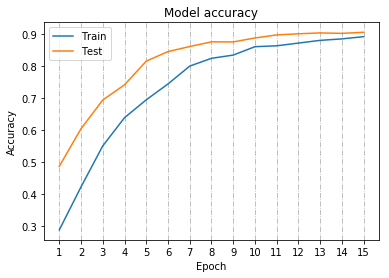

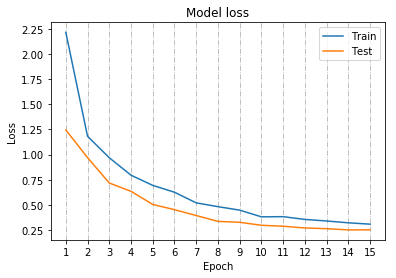

In [14]:
%pylab inline
import matplotlib.pyplot as plt

h_xdim = np.arange(1, epochs+1)
# plot train & test accuracy
plt.plot(h_xdim, history.history['acc'])
plt.plot(h_xdim, history.history['val_acc'])
plt.title('Model accuracy')
plt.xticks(h_xdim)
plt.grid(True, axis='x', linestyle='-.')
#plt.xlim(1, epochs+1)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.savefig('ACC.png')
plt.show()

# plot train & test loss
plt.plot(h_xdim, history.history['loss'])
plt.plot(h_xdim, history.history['val_loss'])
plt.title('Model loss')
plt.xticks(h_xdim)
plt.grid(True, axis='x', linestyle='-.')
#plt.xlim(0, epochs+1)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.savefig('LOSS.png')
plt.show()

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 11, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 5, 16)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 5, 96)         13920     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 2, 96)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 2, 96)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 960)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               123008    
__________

In [16]:
# Predicts one sample
def predict(filepath, model):
    sample = wav2mfcc(filepath)
    sample_reshaped = sample.reshape(1, feature_dim_1, feature_dim_2, channel)
    
    #return get_labels()
    return get_labels()[0][model.predict_classes(sample_reshaped)[0]]
    #return get_labels()[0][np.argmax(model.predict(sample_reshaped))] #same as up line
    #return model.predict(sample_reshaped)

In [17]:
#'./testSample/three_00b01445_nohash_0.wav' zero_0a2b400e_nohash_0 one_00f0204f_nohash_0 two_00b01445_nohash_0
#'./testSample/Two01.wav' Two02.wav

predict('./testSample/Two01.wav', model)

'two'

In [18]:
get_labels()

(['one', 'three', 'two', 'zero'], array([0, 1, 2, 3]), array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], dtype=float32))

In [19]:
scores = model.evaluate(X_test, y_test_hot)

6217/6217 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 79us/step


In [20]:
#scores
print('validation_data-Accuracy:\t', scores[1])
print('validation_data-Loss:\t', scores[0])
#model.metrics_names

validation_data-Accuracy:	 0.9057423194466785
validation_data-Loss:	 0.2540683141674799


In [21]:
distinguish = model.predict_classes(X_test)
distinguish[:]

array([1, 3, 2, ..., 3, 2, 3], dtype=int64)

---